# Load Data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from matplotlib.colors import Normalize

def load_data():
    """ Load the .mat files from the Dataset

    Returns: 
        data: a collection of 2-d points
    """
    data = sio.loadmat("./data/dataset")["Points"]
    
    return data

data = load_data()
for point in data:
       plt.scatter(x=point[0],y=point[1],color=cm.jet(0.), label='data')

# DBSCAN

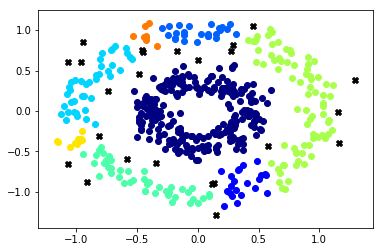

In [2]:
def vis_cluster(data, labels):

    label_list = list(set(labels))

    norm = Normalize(vmin=0, vmax=len(label_list))

    for index in range(len(data)):

        if labels[index] != -1:
            plt.scatter(x=data[index][0],y=data[index][1], color=cm.jet(norm(labels[index])))
        else:
            plt.scatter(x=data[index][0],y=data[index][1], color='black', marker = "X")


data = load_data()

clustering = DBSCAN(eps=0.12, min_samples=3).fit(data)

labels = clustering.labels_

vis_cluster(data, labels)
plt.show()



# K-means

In [3]:
import time
import math
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize

class k_means:
    def __init__(self, k=2, tol=0.001, max_iter=100):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self, data):
        self.centroids = {}
        
        # Initialize with first two data points
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        # Optimize in each iteration and update the centroids until hit the tolerance or max_iter
        for i in range(self.max_iter):
            self.labels = {}
            
            for i in range(self.k):
                self.labels[i] = []
                
            for point in data:
                distance_list = [math.hypot(point[0] - self.centroids[i][0], point[1] - self.centroids[i][1]) for i in range(self.k)]
                label = distance_list.index(min(distance_list))
                self.labels[label].append(point)
            
            prev_centroids = self.centroids
            
            for label in self.labels:
                # Update the new centroid
                self.centroids[label] = np.average(self.labels[label], axis=0)
            
            next_iter = True
            
            for i in self.centroids:
                if np.sum((self.centroids[i] - prev_centroids[i])/self.centroids[i] * 100.00) < self.tol:
                    next_iter = False
            
            if not next_iter:
                break
                    
    def predict(self,data):
        labels = []
        for point in data:
            distance_list = [math.hypot(point[0] - self.centroids[i][0], point[1] - self.centroids[i][1]) for i in range(self.k)]
            label = distance_list.index(min(distance_list))
            labels.append(label)
        return labels

In [4]:
k = [2, 10, 20, 30]

In [5]:
clustering_1 = k_means(k=2)
clustering_2 = k_means(k=10)
clustering_3 = k_means(k=20)
clustering_4 = k_means(k=30)

In [6]:
data = load_data()
clustering_1.fit(data)
clustering_2.fit(data)
clustering_3.fit(data)
clustering_4.fit(data)

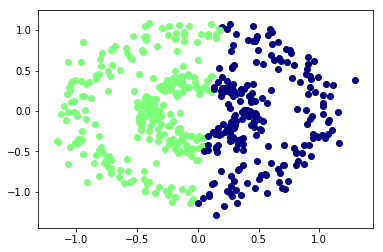

In [7]:
vis_cluster(data, clustering_1.predict(data))

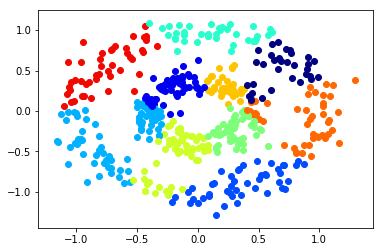

In [8]:
vis_cluster(data, clustering_2.predict(data))

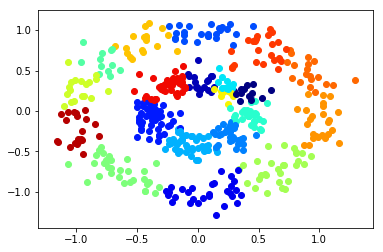

In [9]:
vis_cluster(data, clustering_3.predict(data))

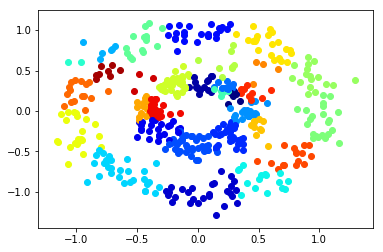

In [10]:
vis_cluster(data, clustering_4.predict(data))

# Fuzzy Clustering EM

In [11]:
import numpy as np
import math
import random

class fuzzy_cluster:
    def __init__(self, tol=0.001, max_iter=200):
        self.k = 2
        self.tol = tol
        self.max_iter = max_iter
    
    def distance(self, x, y):
        return math.hypot(x[0] - y[0], x[1] - y[1])
    
    def compute_wt(self, o, c_1, c_2):
        wt_1 = self.distance(o, c_2)**2 / (self.distance(o, c_2)**2 + self.distance(o, c_1)**2)
        wt_2 = 1 - wt_1
        
        return wt_1, wt_2
    
    def update_centroid(self, label, data_x, data_y):
        centroid_x = np.sum(np.multiply(np.power(label,2), data_x)) / np.sum(np.power(label,2))
        centroid_y = np.sum(np.multiply(np.power(label,2), data_y)) / np.sum(np.power(label,2))
        
        return [centroid_x, centroid_y]
    
    def compute_sse(self, centroids, data, labels):
        sse = 0
        for i in range(len(data)):
            wt = labels[i]
            sse_1 = wt[0]**2 * self.distance(data[i], centroids[0])**2
            sse_2 = wt[1]**2 * self.distance(data[i], centroids[1])**2
            sse = sse + sse_1 + sse_2
        return sse
    
    def fit(self, data):
        self.centroids = []
            
        # Initialize with first two data points
        for i in range(self.k):
            self.centroids.append(data[i])
        print("Initial Centroids: ", self.centroids)
        
        # Optimize in each iteration and update the centroids until hit the tolerance or max_iter
        for i in range(self.max_iter):
            self.labels = []
                
            for point in data:
                wt_1, wt_2 = self.compute_wt(point, self.centroids[0], self.centroids[1])
                self.labels.append([wt_1, wt_2])
            
            label_T = np.array(self.labels).transpose()
            data_x = data.transpose()[0]
            data_y = data.transpose()[1]
            prev_centroids = self.centroids[:]
            
            for k in range(self.k):
                # Update the new centroid
                self.centroids[k] = self.update_centroid(label_T[k], data_x, data_y)
             
            print("The sum of SSE: ", self.compute_sse(self.centroids, data, self.labels))
            print ("When iter=%i Centroids: " % i, self.centroids)
    

            if (np.allclose(prev_centroids, self.centroids, atol=self.tol)):
                print("Converge and break!")
                break
            
            if i == self.max_iter-1:
                print("Warning: Not converge!")
                    
    def predict(self,data):
        labels = []
        for point in data:
            wt_1, wt_2 = self.compute_wt(point, self.centroids[0], self.centroids[1])
            labels.append([wt_1, wt_2])
        return labels, self.centroids

In [12]:
data = load_data()

clustering = fuzzy_cluster(tol=0.0001, max_iter=400)
    
clustering.fit(data)

labels, centroids = clustering.predict(data)

Initial Centroids:  [array([0.27941276, 0.22447095]), array([0.10405864, 0.24013842])]
The sum of SSE:  149.41587316963313
When iter=0 Centroids:  [[0.16290241534498523, -0.014171766454081648], [-0.13111815490943737, 0.020515476063628416]]
The sum of SSE:  143.5949963870702
When iter=1 Centroids:  [[0.24439233959548182, -0.03725748266174766], [-0.2363297060271552, 0.015236779859290802]]
The sum of SSE:  138.86969773480777
When iter=2 Centroids:  [[0.32575665536756254, -0.04472100123172748], [-0.3189730650049596, 0.020312203853585908]]
The sum of SSE:  136.82398971304156
When iter=3 Centroids:  [[0.371887048994533, -0.04655968299920525], [-0.365058098943317, 0.021929362994347494]]
The sum of SSE:  136.37458574848046
When iter=4 Centroids:  [[0.39161939391417944, -0.04536534705025815], [-0.3848341088086044, 0.02070001299738475]]
The sum of SSE:  136.30093958958662
When iter=5 Centroids:  [[0.3991119063882626, -0.042867041803705576], [-0.3924316745220235, 0.01824382559615839]]
The sum of 

The sum of SSE:  135.53788046284723
When iter=111 Centroids:  [[0.2987686751072764, 0.26935880049996613], [-0.296351330693605, -0.2888298811556791]]
The sum of SSE:  135.53567914560733
When iter=112 Centroids:  [[0.2975599461018926, 0.27066145341265957], [-0.29514697884429564, -0.29016887152121135]]
The sum of SSE:  135.53355016751152
When iter=113 Centroids:  [[0.29636549138765417, 0.27193674235082027], [-0.2939566911935846, -0.29148066954115964]]
The sum of SSE:  135.531491451505
When iter=114 Centroids:  [[0.2951853717733095, 0.2731851942478519], [-0.2927805361111612, -0.2927657716427318]]
The sum of SSE:  135.5295009587994
When iter=115 Centroids:  [[0.29401963487920607, 0.2744073309983266], [-0.29161856853467233, -0.294024670438173]]
The sum of SSE:  135.52757668978998
When iter=116 Centroids:  [[0.2928683157301291, 0.2756036691059081], [-0.2904708305706827, -0.2952578543518254]]
The sum of SSE:  135.5257166848146
When iter=117 Centroids:  [[0.29173143733601087, 0.2767747193647634

When iter=209 Centroids:  [[0.236221481831138, 0.3235995798182821], [-0.2338470747585662, -0.3456199096537688]]
The sum of SSE:  135.4762445823074
When iter=210 Centroids:  [[0.2359756921947098, 0.32376861796526396], [-0.23360077057820766, -0.3458011972537244]]
The sum of SSE:  135.47618406204077
When iter=211 Centroids:  [[0.2357343023931594, 0.323934346337923], [-0.2333588703358592, -0.34597896974053144]]
The sum of SSE:  135.47612575156003
When iter=212 Centroids:  [[0.2354972364558184, 0.3240968327832788], [-0.23312129817324975, -0.3461532979729574]]
The sum of SSE:  135.47606957029322
When iter=213 Centroids:  [[0.2352644196048853, 0.3242561436629755], [-0.2328879794164951, -0.34632425129846556]]
The sum of SSE:  135.47601544059586
When iter=214 Centroids:  [[0.23503577824208918, 0.3244123438883427], [-0.23265884056312747, -0.34649189758760984]]
The sum of SSE:  135.47596328764584
When iter=215 Centroids:  [[0.23481123993522823, 0.32456549695458137], [-0.23243380926898605, -0.3466

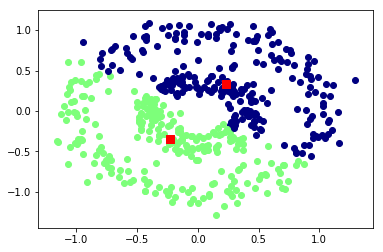

In [13]:
max_labels = []
for label in labels:
    max_labels.append(np.argmax(label))

vis_cluster(data, max_labels)

for i in range(len(centroids)):
    plt.scatter(x=centroids[i][0],y=centroids[i][1], color='red', marker="s", s=50)
plt.show()